In [1]:
include("../init-notebook.jl")
disable_logging(Logging.Warn)

LogLevel(1001)

(section-linsys-efficiency)=
# Efficiency of matrix computations

Predicting how long an algorithm will take to solve a particular problem, on a particular computer, as written in a particular way in a particular programming language, is an enormously difficult undertaking. It's more practical to predict how the required time will scale as a function of the size of the problem. In the case of a linear system of equations, the problem size is $n$, the number of equations variables in the system.  Because expressions of computational time are necessarily approximate, it's customary to suppress all but the term that is dominant as $n\to\infty$. We first need to build some terminology for these expressions.

```{index} ! asymptotic notation
```

## Asymptotic analysis

::::{proof:definition} Asymptotic notation
Let $f(n)$ and $g(n)$ be positive-valued functions. We say $f(n)=O(g(n))$ (read "$f$ is **big-O** of $g$") as $n\rightarrow \infty$ if $f(n)/g(n)$ is bounded above as $n\to\infty$.

We say $f(n)\sim g(n)$ (read "$f$ is **asymptotic** to $g$") as $n\rightarrow \infty$ if $f(x)/g(x)\rightarrow 1$ as $n\rightarrow\infty$.
::::

One immediate consequence is that $f\sim g$ implies $f=O(g)$.[^sets]

[^sets]: More precisely, $O(g)$ and $\sim g$ are *sets* of functions, and $\sim g$ is a subset of $O(g)$. That we write $f=O(g)$ rather than $f\in O(g)$ is a quirk of convention.

````{proof:example}
Consider the functions $f(n) = a_1 n^3 + b_1 n^2 + c_1 n$ and $g(n) = a_2 n^3$ in the limit $n\to \infty$.  Then
  
```{math}
    \lim_{n \to \infty} \frac{f(n)}{g(n)}
    = \lim_{n \to \infty} \frac{a_1 + b_1n^{-1} + c_1n^{-2}}{a_2} =
    \frac{a_1}{a_2} .
```

Since $a_1/a_2$ is a constant, $f(n) = O(g(n))$; if $a_1=a_2$, then $f \sim g$.
````

````{proof:example}
  Consider $f(n) = \sin (1/n)$, $g(n)=1/n$ and $h(n) = 1/n^2$. For large $n$, Taylor's theorem with remainder implies that
  
```{math}
f(n) = \frac{1}{n} - \cos(1/\xi)\frac{1}{6 n^3},
```

where $n<\xi<\infty$.  But
  
```{math}
\lim_{n\to \infty} \frac{f}{g} = \lim_{n\to \infty} 1-\cos(1/\xi)\frac{1}{6 n^2} = 1,
```

and so $f \sim g$.  On the other hand, comparing $f$ and $h$, we find

```{math}
\lim_{n\to \infty} \frac{f}{h} = \lim_{n\to \infty}  n-\cos(1/\xi)\frac{1}{6 n} = \infty,
```

so we cannot say that $f = O(h)$. A consideration of $h/f$ will show that $h = O(f)$, however.
````

It's conventional to use asymptotic notation that is as specific as possible. For instance, while it is true that $n^2+n=O(n^{10})$, it's more informative, and usually expected, to say $n^2+n=O(n^2)$. There are additional notations that enforce this requirement strictly, but we will just stick to the informal understanding.

There is a memorable way to use asymptotic notation to simplify sums:

```{math}
:label: sumflops
\begin{split}
  \sum_{k=1}^n k&\sim \frac{n^2}{2} = O(n^2), \text{ as $n\to\infty$}, \\
  \sum_{k=1}^n k^2 &\sim \frac{n^3}{3} = O(n^3), \text{ as $n\to\infty$}, \\
  &\vdots \\
  \sum_{k=1}^n k^p &\sim \frac{n^{p+1}}{p+1} = O(n^{p+1}), \text{ as $n\to\infty$},
\end{split}
```

These formulas greatly resemble the definite integral of $x^p$. 

(example-efficiency-sums)=
::::{proof:example}
\begin{align*}
\sum_{k=1}^{n-1} 4k^2 + 3 & = 4 \left( \sum_{k=1}^{n-1} k^2\right)  + 3 \sum_{k=1}^{n-1} 1\\ 
&\sim 4 \left( \frac{1}{3} (n-1)^3 \right) + 3(n-1) \\ 
& = \frac{4}{3} (n^3 + 3n^2 + 3n - 1)  + 3n - 3 \\ 
&\sim \frac{4}{3} n^3.
\end{align*}
::::
## Flop counting

```{index} flops
```

Traditionally, in numerical linear algebra we count **floating-point operations**, or **flops** for short. In our interpretation each scalar addition, subtraction, multiplication, division, and square root counts as one flop. Given any algorithm, we can simply add up the number of scalar flops and ignore everything else.

(demo-flops-mvmult)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```


Here is a straightforward implementation of matrix-vector multiplication.

In [2]:
n = 6
A,x = randn(n,n),rand(n)
y = zeros(n)
for i in 1:n
    for j in 1:n
        y[i] += A[i,j]*x[j]    # 1 multiply, 1 add
    end
end

Each of the loops implies a summation of flops. The total flop count for this algorithm is

$$ \sum_{i=1}^n \sum_{j=1}^n 2 = \sum_{i=1}^n 2n = 2n^2. $$

Since the matrix $\mathbf{A}$ has $n^2$ elements, all of which have to be involved in the product, it seems unlikely that we could get a flop count that is smaller than $O(n^2)$ in the general case.

```{index} ! Julia; push\!, ! Julia; for
```

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
Let's run an experiment with the built-in matrix-vector multiplication. Note that Julia is unusual in that loops have a variable scope separate from its enclosing code. Thus, `for n in n` below means that inside the loop, the name `n` will take on each one of the values that were previously assigned to the vector `n`.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The `push!` function attaches a new value to the end of a vector.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [3]:
n = 1000:1000:5000
t = []
for n in n
    A = randn(n,n)  
    x = randn(n)
    time = @elapsed for j in 1:80; A*x; end
    push!(t,time)
end

The reason for doing multiple repetitions at each value of $n$ in the loop above is to avoid having times so short that the resolution of the timer is significant.

In [4]:
pretty_table((n=n,t=t),["size" "time";"" "(sec)"],backend=:html)

size,time
,(sec)
1000,0.0683027
2000,0.103051
3000,0.215584
4000,0.311735
5000,0.493484


```{index} Julia; Boolean indexing
```

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
Looking at the timings just for $n=2000$ and $n=4000$, they have ratio

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The expression `n.==4000` here produces a vector of Boolean (true/false) values the same size as `n`. This result is used to index within `t`, accessing only the value for which the comparison is true.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [5]:
@show t[n.==4000] ./ t[n.==2000]

t[n .== 4000] ./ t[n .== 2000] = [3.0250677866400744]


1-element Vector{Float64}:
 3.0250677866400744

If the run time is dominated by flops, then we expect this ratio to be $(4000)^2/(2000)^2=4$.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

Suppose that the running time $t$ of an algorithm obeys a function that is $O(n^p)$. For sufficiently large $n$, $t\approx Cn^p$ for a constant $C$ should be a good approximation. Hence

```{math}
  :label: loglogfit
  t \approx Cn^p \qquad \Longleftrightarrow \qquad \log t \approx p(\log n) + \log C.
```

So we expect that a graph of $\log t$ as a function of $\log n$ will be a straight line of slope $p$.


(demo-flops-loglog)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Let's repeat the experiment of the previous figure for more, and larger, values of $n$.

In [6]:
randn(5,5)*randn(5);  # throwaway to force compilation

n = 400:200:6000
t = []
for n in n
    A = randn(n,n)  
    x = randn(n)
    time = @elapsed for j in 1:50; A*x; end
    push!(t,time)
end

Plotting the time as a function of $n$ on log-log scales is equivalent to plotting the logs of the variables.

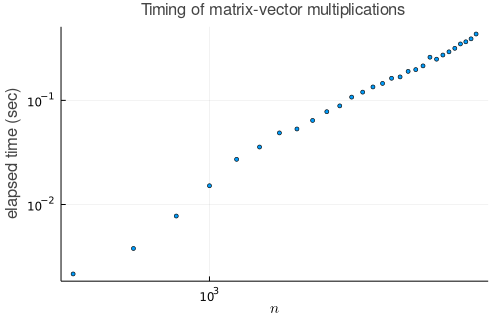

In [7]:
scatter(n,t,label="data",
    xaxis=(:log10,L"n"), yaxis=(:log10,"elapsed time (sec)"),
    title="Timing of matrix-vector multiplications",legend=false)

You can see that while the full story is complicated, the graph is trending to a straight line of positive slope. For comparison, we can plot a line that represents $O(n^2)$ growth exactly. (All such lines have slope equal to 2.)

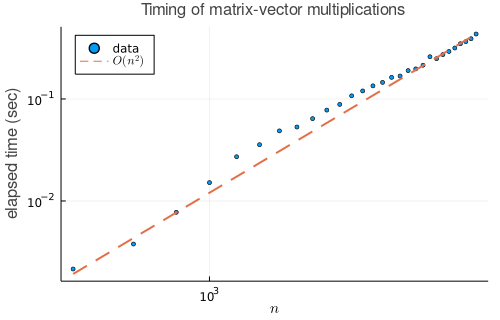

In [8]:
plot!(n,t[end]*(n/n[end]).^2,l=:dash,label=L"O(n^2)",legend=:topleft)

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Solution of linear systems

Recall the steps of {numref}`Algorithm {number} <algorithm-lu-solve>` for the system $\mathbf{A}\mathbf{x}=\mathbf{b}$:

1. Factor $\mathbf{L}\mathbf{U}=\mathbf{A}$ using Gaussian elimination.
2. Solve $\mathbf{L}\mathbf{z}=\mathbf{b}$ for $\mathbf{z}$ using forward substitution.
3. Solve $\mathbf{U}\mathbf{x}=\mathbf{z}$ for $\mathbf{x}$ using backward substitution.

The second and third steps are solved by {numref}`Function {number} <function-forwardsub>` and {numref}`Function {number} <function-backsub>`. Only one line in each of these functions performs any arithmetic. Take `forwardsub`, for instance. It has a single flop in line 11.  Line 13 computes

```julia  
sum( L[i,j]*x[j] for j in 1:i-1 )
```

This line requires $i-1$ multiplications and $(i-2)$ additions, for a total of $2i-3$ flops. Line 14 adds two more flops. These lines are performed within a loop as $i$ ranges from 1 to $n$, so the total count is

```{math}
  :label: trisolveflops
  1 + \sum_{i=1}^n (2i-3) = 1 - 3n + 2 \sum_{i=1}^n i.
```

It is not hard to find an exact formula for the sum, but we use {eq}`sumflops` to simplify it to $\sim n^2$.[^useasymp] An analysis of backward substitution yields the same result.

[^useasymp]: Since flop counting is only an approximation of true running time, why bother with a more complicated exact expression? The asymptotic formula contains most of whatever relevant information there is.

```{proof:lemma}
Solving a triangular $n\times n$ system by forward or backward substitution takes $\sim n^2$ flops asymptotically.
```

Before counting flops for the LU factorization, we have to admit that {numref}`Function {number} <function-lufact>` is not written as economically as it could be. Recall from our motivating example in {numref}`Demo {number} <demo-lu-derive>` that we zero out the first row and column of $\mathbf{A}$ with the first outer product, the second row and column with the second outer product, and so on. There is no good reason to do multiplications and additions with values known to be zero, so we could replace lines 15–19 of `lufact` with

```{code-block} julia
:lineno-start: 15
for k in 1:n-1
    U[k,k:n] = Aₖ[k,k:n]
    L[k:n,k] = Aₖ[k:n,k]/U[k,k]
    Aₖ[k:n,k:n] -= L[k:n,k]*U[k,k:n]'
end
```

We will use the following handy fact.
:::{proof:observation}
The range `k:n`, where $k\le n$, has $n-k+1$ elements.
:::

Line 17 above divides the each element of the vector `Aₖ[k:n,k]` by a scalar. Hence the number of flops equals the length of the vector, which is $n-k+1$. 

Line 18 has an outer product, followed by a matrix subtraction. The definition {eq}`def-outerprod` of the outer product makes it clear that that computation takes one flop (multiplication) per element of the result, which here results in $(n-k+1)^2$ flops. The number of subtractions is identical. 

Altogether the factorization takes

```{math}
:label: gecount1
\sum_{k=1}^{n-1} n-k + 1 + 2(n-k+1)^2.
```

There are different ways to simplify this expression. We will make a change of summation index using $j=n-k$. The endpoints of the sum are $j=n-1$ when $k=1$ and $j=1$ when $k=n-1$. Since the order of terms in a sum doesn't matter, we get

```{math}
\sum_{j=1}^{n-1} 1+j+2(j+1)^2 &=  \sum_{j=1}^{n-1} 3 + 5j + 2j^2 \\
  & \sim  3(n-1) + \frac{5}{2}(n-1)^2 \frac{2}{3}(n-1)^3 \\
  & \sim \frac{2}{3}n^3.
```

We have proved the following. 
```{proof:theorem} Efficiency of LU factorization
The LU factorization of an $n\times n$ matrix takes $\sim\frac{2}{3}n^3$ flops as $n\to \infty$. This dominates the flops for solving an $n\times n$ linear system.
```

(demo-flops-lufact)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
We'll test the conclusion of $O(n^3)$ flops experimentally, using the built-in `lu` function instead of the purely instructive `lufact`.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The first time a function is invoked, there may be significant time needed to compile it in memory. Thus, when timing a function, run it at least once before beginning the timing.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [9]:
lu(randn(3,3));   # throwaway to force compilation

n = 400:400:4000
t = []
for n in n
    A = randn(n,n)  
    time = @elapsed for j in 1:12; lu(A); end
    push!(t,time)
end

We plot the timings on a log-log graph and compare it to $O(n^3)$. The result could vary significantly from machine to machine, but in theory the data should start to parallel the line as $n\to\infty$.

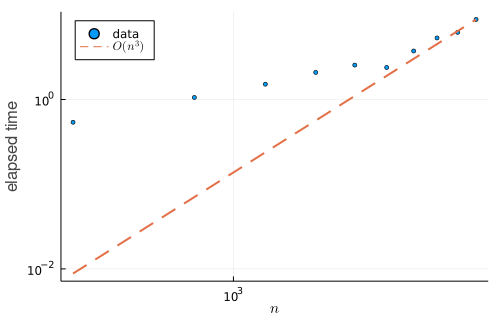

In [10]:
scatter(n,t,label="data",
    xaxis=(:log10,L"n"), yaxis=(:log10,"elapsed time"),legend=:topleft)
plot!(n,t[end]*(n/n[end]).^3,l=:dash,label=L"O(n^3)")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


In practice, flops are not the only aspect of an implementation that occupies significant time. Our position is that counting flops as a measure of performance is a useful oversimplification. We will assume that LU factorization (and as a result, the solution of a linear system of $n$ equations) requires a real-world time that is roughly $O(n^3)$. This growth rate is a great deal more tolerable than, say, $O(2^n)$, but it does mean that for (at this writing) $n$ greater than 10,000 or so, something other than general LU factorization will have to be used.

## Exercises

1. ✍ The following are asymptotic assertions about the limit $n\rightarrow\infty$. In each case, prove the statement true or false.

    **(a)** $n^2 = O(\log n),\quad$ 
    **(b)** $n^{a} = O(n^b)$ if $a\le b,\quad$
    **(c)** $e^n \sim e^{2n},\quad$
    **(d)** $n+\sqrt{n}\sim n+2\sqrt{n}$.

2. ✍ The following are asymptotic assertions about the limit $h\to 0$. In each case, prove the statement true or false.

    **(a)** $h^2\log(h) = O(h^3),\quad$
    **(b)** $h^{a} = O(h^b)$ if $a < b,\quad$
    **(c)** $\sin(h) \sim h,\quad$
    **(d)** $(e^{2h}-1)\sim h$.

3. ✍ Show that the inner product of two $n$-vectors takes exactly $2n-1$ flops.

4. ✍ Show that the multiplication of two $n\times n$ matrices takes $\sim 2n^3$ flops.

5. ✍ This problem is about evaluation of a polynomial $c_1 + c_2 x + \cdots + c_{n}x^{n-1}$.
  
    **(a)** Here is a little code to do the evaluation.

    ``` julia
    y = c[1]
    xpow = 1
    for i in 2:n
        xpow *= x
        y += c[i]*xpow
    end
    ```

    Assuming that `x` is a scalar, how many flops does this function take, as a function of $n$?

    **(b)** Compare the count from (a) to the flop count for Horner's algorithm, {numref}`Function {number} <function-horner>`.
  
6. The exact sums for $p=1,2$ in {eq}`sumflops` are as follows:
  
    ```{math}
    \sum_{k=1}^{n} k = \frac{n(n+1)}{2}, \qquad 
    \sum_{k=1}^{n} k^2 = \frac{n(n+1)(2n+1)}{6}.
    ```

    **(a)** ✍  Use these to find the exact result for {eq}`gecount1`.

    **(b)** ⌨ Plot the ratio of your result from (a) and the asymptotic result $2n^3/3$ for all $n=10^{1+0.03i}$, $i=0,\dots,100$, using a log scale for $n$ and a linear scale for the ratio. (The curve should approach 1 asymptotically.)
  

7. ✍ Show that for any nonnegative constant integer $m$,
  
    ```{math}
    \sum_{k=0}^{n-m} k^p \sim \frac{n^{p+1}}{p+1}.
    ```

8. ⌨ The `UpperTriangular` and `LowerTriangular` matrix types cause specialized algorithms to be invoked by the backslash. Define

    ```
    A = rand(1000,1000)
    B = tril(A)
    C = LowerTriangular(B)
    b = rand(1000)
    ```

    Using `@elapsed` with the backslash solver, time how long it takes to solve the linear system $\mathbf{A}\mathbf{x}=\mathbf{b}$ 100 times, then do the same for matrices $\mathbf{B}$ and $\mathbf{C}$. Is the timing for $\mathbf{B}$ closer to $\mathbf{A}$ or to $\mathbf{C}$? (Hint: Remember to make one timing run without recording results, so that compilation time is not counted.)